In [8]:
import torch
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
import numpy as np
import pandas as pd

import torchvision
from dataloaders.tasks_provider import prepare_classes_list, TaskList
import torch.nn.functional as F

In [2]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in C:\Users\QbaSo/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
def get_nodes_to_extract(model, activation_name):
    nodes = get_graph_node_names(model)[1] # 1 mean model.eval layers

    nodes_to_extract = []

    for node in nodes:
        if activation_name in node:
            nodes_to_extract.append(node)

    return nodes_to_extract

def extract_activations(x, model_feature_extractor, inference=False, binary=False):
    extracted_features = model_feature_extractor(x)

    layers = list(extracted_features.keys())

    activations = extracted_features[layers[0]].flatten(1).cpu().detach().numpy()
    n_activation = activations.shape[0]
    for layer in layers[1:]:
        activations = np.concatenate((activations, extracted_features[layer].flatten(1).cpu().detach().numpy()), axis=1)

    if binary:
        activations = activations > 0
    
    if inference:
        return activations, n_activation

    return activations.sum(0), n_activation

In [5]:
nodes = get_graph_node_names(model)[1] # 1 mean model.eval layers

nodes_to_extract = []

for node in nodes:
    if "relu" in node:
        nodes_to_extract.append(node)

nodes_to_extract = nodes_to_extract[-5:] # using only last 5 layers
print(nodes_to_extract)

['layer3.1.relu_1', 'layer4.0.relu', 'layer4.0.relu_1', 'layer4.1.relu', 'layer4.1.relu_1']


In [6]:
model_feature_extractor = create_feature_extractor(model, return_nodes=nodes_to_extract)

In [7]:
num_classes, classes_per_task = 10, 2
classes_list = prepare_classes_list(num_classes, classes_per_task)
tasks = TaskList(classes_list, 128, torchvision.datasets.CIFAR10)
tasks_test = TaskList(classes_list, 128, torchvision.datasets.CIFAR10, train=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
for x, y in tasks.tasks[0].dataloader:
    break

In [9]:
extracted_features = model_feature_extractor(x)

layers = list(extracted_features.keys())

activations = extracted_features[layers[0]].flatten(1).cpu().detach().numpy()
n_activation = activations.shape[0]
for layer in layers[1:]:
    activations = np.concatenate((activations, extracted_features[layer].flatten(1).cpu().detach().numpy()), axis=1)

activations.sum(0)

array([ 36.596817,  14.7539  ,  25.385822, ..., 111.33015 , 128.26216 ,
       119.492615], dtype=float32)

# MNIST

# Ideas
* distance ^2 ^3
* distance only for activated
* Hamming distance

In [5]:
def train(model, dataloader, epoch, device, optimizer, binary=False):
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(dataloader):

            output = model(data.to(device))
            loss = F.cross_entropy(output, target.to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if batch_idx % 10 == 0:
                print(f"Epoch: {e} [{batch_idx} / {len(dataloader)}] loss: {loss:.5f}")

    # naps
    for x, y in dataloader:
        example_activations, _ = extract_activations(x=x.to(device) , model_feature_extractor=model_feature_extractor)
        break
    activations_sum = {i: np.zeros(example_activations.shape) for i in range(10)}
    n_activation = {i: 0 for i in range(10)}
    for x, y in dataloader:
        for curr_y in np.unique(y):
            curr_activations_sum, curr_n_activation = extract_activations(x=x[y==curr_y].to(device) , model_feature_extractor=model_feature_extractor, binary=binary)
            activations_sum[curr_y] += curr_activations_sum
            n_activation[curr_y] += curr_n_activation
    for i in range(10):
        activations_sum[i] /= n_activation[i]
    return activations_sum, n_activation

def test(model, test_loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].cpu()
            correct += pred.eq(target.data.view_as(pred)).sum()
    return float(100. * correct / len(test_loader.dataset))

# 1 Epoch

In [6]:
from utils import get_device
from torch import optim
from dataloaders.mnist import MNIST
from Nets import MNIST_net

model = MNIST_net(10)
nodes_to_extract = get_nodes_to_extract(model=model, activation_name='relu')

# nodes_to_extract = [nodes_to_extract[2]]
model_feature_extractor = create_feature_extractor(model=model, return_nodes=nodes_to_extract)

train_loader, val_loader, test_loader = MNIST()

model.train()
optimizer = optim.SGD(model.parameters(), lr=0.1)
device = get_device()
activations_epochs = train(model.to(device), train_loader, 1, device, optimizer)
print(f"test accuracy: {test(model, test_loader, device)}")

Epoch: 0 [0 / 782] loss: 2.50648
Epoch: 0 [10 / 782] loss: 0.28275
Epoch: 0 [20 / 782] loss: 0.18687
Epoch: 0 [30 / 782] loss: 0.11036
Epoch: 0 [40 / 782] loss: 0.19889
Epoch: 0 [50 / 782] loss: 0.12590
Epoch: 0 [60 / 782] loss: 0.20153
Epoch: 0 [70 / 782] loss: 0.03785
Epoch: 0 [80 / 782] loss: 0.15758
Epoch: 0 [90 / 782] loss: 0.07449
Epoch: 0 [100 / 782] loss: 0.04040
Epoch: 0 [110 / 782] loss: 0.19278
Epoch: 0 [120 / 782] loss: 0.03543
Epoch: 0 [130 / 782] loss: 0.16956
Epoch: 0 [140 / 782] loss: 0.12306
Epoch: 0 [150 / 782] loss: 0.04294
Epoch: 0 [160 / 782] loss: 0.04887
Epoch: 0 [170 / 782] loss: 0.02966
Epoch: 0 [180 / 782] loss: 0.02608
Epoch: 0 [190 / 782] loss: 0.12009
Epoch: 0 [200 / 782] loss: 0.02873
Epoch: 0 [210 / 782] loss: 0.05395
Epoch: 0 [220 / 782] loss: 0.13571
Epoch: 0 [230 / 782] loss: 0.08369
Epoch: 0 [240 / 782] loss: 0.05439
Epoch: 0 [250 / 782] loss: 0.01281
Epoch: 0 [260 / 782] loss: 0.03699
Epoch: 0 [270 / 782] loss: 0.06023
Epoch: 0 [280 / 782] loss: 0.03

In [9]:
extracted_activations = np.stack([activations_epochs[0][i] for i in range(10)], axis=1)

preds = []
y_test = []

for x, y in test_loader:
    y_test.extend(y)
    test_activations, curr_n_activation = extract_activations(x=x.to(device) , model_feature_extractor=model_feature_extractor, inference=True)
    for activation in test_activations:
        preds.append(np.argmin(np.abs(extracted_activations - np.expand_dims(activation, 1)).sum(0)))

preds = np.array(preds)
pd.Series(preds == np.array(y_test)).value_counts()

True     8907
False    1093
dtype: int64

# 5 Epoch

In [10]:
activations_epochs = train(model.to(device), train_loader, 4, device, optimizer)
print(f"test accuracy: {test(model, test_loader, device)}")

Epoch: 0 [0 / 782] loss: 0.01038
Epoch: 0 [10 / 782] loss: nan
Epoch: 0 [20 / 782] loss: nan
Epoch: 0 [30 / 782] loss: nan
Epoch: 0 [40 / 782] loss: nan
Epoch: 0 [50 / 782] loss: nan
Epoch: 0 [60 / 782] loss: nan
Epoch: 0 [70 / 782] loss: nan
Epoch: 0 [80 / 782] loss: nan
Epoch: 0 [90 / 782] loss: nan
Epoch: 0 [100 / 782] loss: nan
Epoch: 0 [110 / 782] loss: nan
Epoch: 0 [120 / 782] loss: nan
Epoch: 0 [130 / 782] loss: nan
Epoch: 0 [140 / 782] loss: nan
Epoch: 0 [150 / 782] loss: nan
Epoch: 0 [160 / 782] loss: nan
Epoch: 0 [170 / 782] loss: nan
Epoch: 0 [180 / 782] loss: nan
Epoch: 0 [190 / 782] loss: nan
Epoch: 0 [200 / 782] loss: nan
Epoch: 0 [210 / 782] loss: nan
Epoch: 0 [220 / 782] loss: nan
Epoch: 0 [230 / 782] loss: nan
Epoch: 0 [240 / 782] loss: nan
Epoch: 0 [250 / 782] loss: nan
Epoch: 0 [260 / 782] loss: nan
Epoch: 0 [270 / 782] loss: nan
Epoch: 0 [280 / 782] loss: nan
Epoch: 0 [290 / 782] loss: nan
Epoch: 0 [300 / 782] loss: nan
Epoch: 0 [310 / 782] loss: nan
Epoch: 0 [320 /

In [11]:
extracted_activations = np.stack([activations_epochs[0][i] for i in range(10)], axis=1)

preds = []
y_test = []

for x, y in test_loader:
    y_test.extend(y)
    test_activations, curr_n_activation = extract_activations(x=x.to(device) , model_feature_extractor=model_feature_extractor, inference=True)
    for activation in test_activations:
        preds.append(np.argmin(np.abs(extracted_activations - np.expand_dims(activation, 1)).sum(0)))

preds = np.array(preds)
pd.Series(preds == np.array(y_test)).value_counts()

False    9020
True      980
dtype: int64

# different distance metric

In [12]:
activations_epochs = train(model.to(device), train_loader, 4, device, optimizer, binary=True)
print(f"test accuracy: {test(model, test_loader, device)}")

Epoch: 0 [0 / 782] loss: nan
Epoch: 0 [10 / 782] loss: nan
Epoch: 0 [20 / 782] loss: nan
Epoch: 0 [30 / 782] loss: nan
Epoch: 0 [40 / 782] loss: nan
Epoch: 0 [50 / 782] loss: nan
Epoch: 0 [60 / 782] loss: nan
Epoch: 0 [70 / 782] loss: nan
Epoch: 0 [80 / 782] loss: nan
Epoch: 0 [90 / 782] loss: nan
Epoch: 0 [100 / 782] loss: nan
Epoch: 0 [110 / 782] loss: nan
Epoch: 0 [120 / 782] loss: nan
Epoch: 0 [130 / 782] loss: nan
Epoch: 0 [140 / 782] loss: nan
Epoch: 0 [150 / 782] loss: nan
Epoch: 0 [160 / 782] loss: nan
Epoch: 0 [170 / 782] loss: nan
Epoch: 0 [180 / 782] loss: nan
Epoch: 0 [190 / 782] loss: nan
Epoch: 0 [200 / 782] loss: nan
Epoch: 0 [210 / 782] loss: nan
Epoch: 0 [220 / 782] loss: nan
Epoch: 0 [230 / 782] loss: nan
Epoch: 0 [240 / 782] loss: nan
Epoch: 0 [250 / 782] loss: nan
Epoch: 0 [260 / 782] loss: nan
Epoch: 0 [270 / 782] loss: nan
Epoch: 0 [280 / 782] loss: nan
Epoch: 0 [290 / 782] loss: nan
Epoch: 0 [300 / 782] loss: nan
Epoch: 0 [310 / 782] loss: nan
Epoch: 0 [320 / 782

In [13]:
extracted_activations = np.stack([activations_epochs[0][i] for i in range(10)], axis=1)

preds = []
y_test = []

for x, y in test_loader:
    y_test.extend(y)
    test_activations, curr_n_activation = extract_activations(x=x.to(device) , model_feature_extractor=model_feature_extractor, inference=True, binary=True)
    for activation in test_activations:
        preds.append(np.argmin(np.abs(extracted_activations - np.expand_dims(activation, 1)).sum(0)))

preds = np.array(preds)
pd.Series(preds == np.array(y_test)).value_counts()

False    9020
True      980
dtype: int64

visualization

In [197]:
extracted_activations

array([[0.01412714, 0.90021383, 0.00546338, ..., 0.07295476, 0.0290924 ,
        0.04391418],
       [0.4074672 , 0.21222381, 0.05807365, ..., 0.81193455, 0.41610326,
        0.9464608 ],
       [0.41917255, 0.99572345, 0.37940105, ..., 0.26005775, 0.9323909 ,
        0.66372569],
       ...,
       [0.06478305, 0.80666429, 0.24645892, ..., 0.98267565, 0.65806187,
        0.99258071],
       [0.46599395, 0.98645759, 0.41643059, ..., 0.94995188, 0.05183364,
        0.07359134],
       [0.76589304, 0.98200285, 0.5471469 , ..., 0.77401347, 0.16062282,
        0.35993583]])

In [196]:
np.abs(extracted_activations - np.expand_dims(activation, 1))

array([[0.01412714, 0.90021383, 0.00546338, ..., 0.07295476, 0.0290924 ,
        0.04391418],
       [0.4074672 , 0.21222381, 0.05807365, ..., 0.81193455, 0.41610326,
        0.9464608 ],
       [0.58082745, 0.00427655, 0.62059895, ..., 0.73994225, 0.0676091 ,
        0.33627431],
       ...,
       [0.93521695, 0.19333571, 0.75354108, ..., 0.01732435, 0.34193813,
        0.00741929],
       [0.46599395, 0.98645759, 0.41643059, ..., 0.94995188, 0.05183364,
        0.07359134],
       [0.23410696, 0.01799715, 0.4528531 , ..., 0.22598653, 0.83937718,
        0.64006417]])

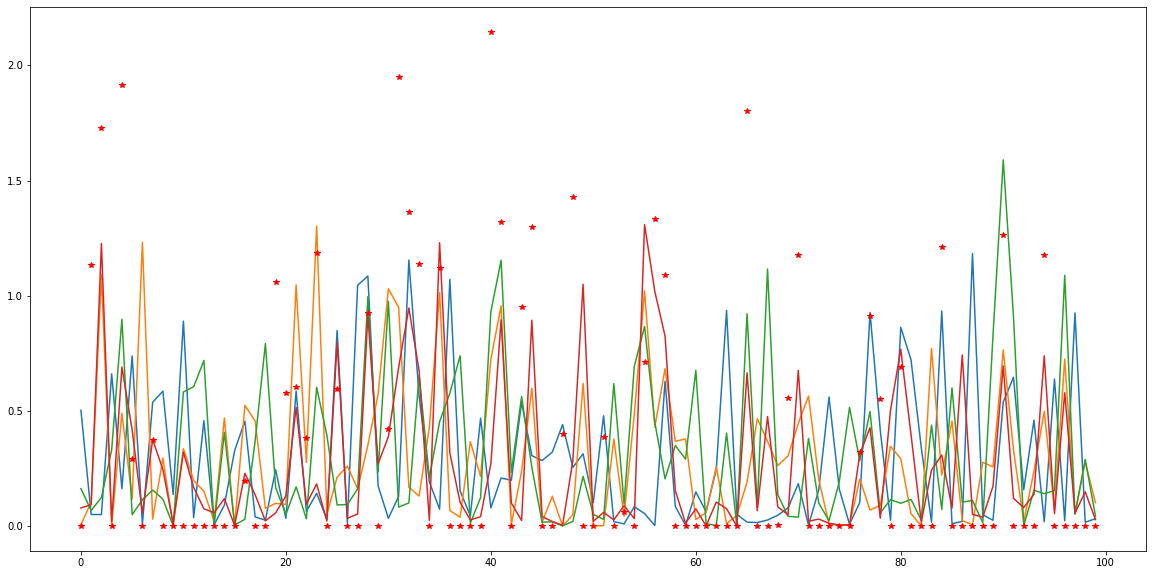

In [180]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(20,10))
for i in range(4):
    plt.plot(activations_epochs[0][i][0:100])

plt.plot(activation[0:100], "*", color="r")

plt.show()